In [1]:
# Import packages
import numpy as np
import pandas as pd

from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import requests
import calendar

import pymc as pm
from scipy import stats

rng = np.random.default_rng(seed=666)

az.style.use("arviz-darkgrid")
pd.options.mode.chained_assignment = None
%matplotlib inline

### Data preprocessing

### Pissouri and Limassol weather datasets

In [9]:
# Read in datasets
pissouri = pd.read_json('C:\my_files\Projects\Probability\Weather/pissouri.json')
limassol = pd.read_json('C:\my_files\Projects\Probability\Weather/limassol.json')

In [10]:
def clean_data(df, city):
    '''
    This function cleans weather datasets and creates some features
    '''
    df['date'] = pd.to_datetime(df['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC')
    df['date'] = df['date'].dt.date
    df['dt_iso+3'] = pd.to_datetime(df['dt_iso'], format='%Y-%m-%d %H:%M:%S +0000 UTC')+timedelta(hours=3)
    df['weather_main'] = df['weather'].apply(lambda x: x[0]['main'])
    df['weather_description'] = df['weather'].apply(lambda x: x[0]['description'])
    df['weather_icon'] = df['weather'].apply(lambda x: x[0]['icon'])
    df['weather_id'] = df['weather'].apply(lambda x: x[0]['id'])
    df['main_feels_like'] = df['main'].apply(lambda x: x['feels_like'])
    df['city'] = city
    df = df[df['main_feels_like']>-100]
    df['day'] = df['dt_iso+3'].dt.day
    df['year'] = df['dt_iso+3'].dt.year
    df['month'] = df['dt_iso+3'].dt.month
    df['hour'] = df['dt_iso+3'].dt.hour
    df['rain'] = np.where(df['weather_main']=='Rain', 1, 0)
    df['wind_speed'] = df['wind'].apply(lambda x: x['speed'])
    
    return df

In [11]:
# Clean the datasets
p = clean_data(pissouri, 'Pissouri')
l = clean_data(limassol, 'Limassol')
df = pd.concat([p,l], axis=0)

In [12]:
df.iloc[:3,:20]

,dt,dt_iso,timezone,main,clouds,weather,visibility,wind,lat,city_name,lon,rain,date,dt_iso+3,weather_main,weather_description,weather_icon,weather_id,main_feels_like,city
0,283996800,1979-01-01 00:00:00 +0000 UTC,7200,"{'temp': 14.77, 'temp_min': 13.63, 'temp_max':...",{'all': 40},"[{'id': 802, 'main': 'Clouds', 'description': ...",10000.0,"{'speed': 3.6, 'deg': 200}",34.664796,Custom location,32.693007,0,1979-01-01,1979-01-01 03:00:00,Clouds,scattered clouds,03n,802,14.44,Pissouri
1,284000400,1979-01-01 01:00:00 +0000 UTC,7200,"{'temp': 14.71, 'temp_min': 13.49, 'temp_max':...",{'all': 34},"[{'id': 802, 'main': 'Clouds', 'description': ...",NaN,"{'speed': 6.15, 'deg': 253}",34.664796,Custom location,32.693007,0,1979-01-01,1979-01-01 04:00:00,Clouds,scattered clouds,03n,802,14.43,Pissouri
2,284004000,1979-01-01 02:00:00 +0000 UTC,7200,"{'temp': 14.5, 'temp_min': 13.28, 'temp_max': ...",{'all': 90},"[{'id': 804, 'main': 'Clouds', 'description': ...",NaN,"{'speed': 5.87, 'deg': 248}",34.664796,Custom location,32.693007,0,1979-01-01,1979-01-01 05:00:00,Clouds,overcast clouds,04n,804,14.23,Pissouri


In [13]:
df.iloc[:3,20:]

,day,year,month,hour,wind_speed
0,1,1979,1,3,3.60
1,1,1979,1,4,6.15
2,1,1979,1,5,5.87


### Sunset-sunrise dataset

In [14]:
# Read in dataset with sunset-sunrise time
api_url = "https://www.data.gov.cy/api/action/datastore/search.json?resource_id=86bb5408-35ba-49fe-94ae-0142d77e64a3&limit=31"
response = requests.get(api_url)
sunrise_sunset_data = response.json()

In [15]:
# Iterate through json file to create dataframe
day = list()
month = list()
sunrise_time = list()
sunset_time = list()

for i in sunrise_sunset_data['result']['records']:
    for key in i:
        if key == 'day':
            day.append(np.full(12,int(i[key])))
        elif key[-4:] == 'a_m_':
            month.append(key.split('_')[0])
            sunrise_time.append(i[key])
        else:
            sunset_time.append(i[key])
        

In [16]:
# Preprocess sunset-sunrise dataset
day_light = pd.DataFrame()
day_light['day'] = np.concatenate(day)
day_light['month'] = month
day_light['sunrise_time'] = sunrise_time
day_light['sunset_time'] = sunset_time
day_light = day_light[day_light['sunrise_time']!='-']
day_light['month'] = day_light['month'].apply(lambda x: x.capitalize())
day_light['month'] = pd.to_datetime(day_light['month'], format='%B').dt.month
day_light['sunrise_hour'] = day_light['sunrise_time'].apply(lambda x: int(x[:-3]))
day_light['sunrise_min'] = day_light['sunrise_time'].apply(lambda x: int(x[-2:]))
day_light['sunset_hour'] = day_light['sunset_time'].apply(lambda x: int(x[:-3]))
day_light['sunset_min'] = day_light['sunset_time'].apply(lambda x: int(x[-2:]))
day_light['sunrise_hour'] = np.where(day_light['sunrise_min']>=30, day_light['sunrise_hour']+1, day_light['sunrise_hour'])
day_light['sunset_hour'] = np.where(day_light['sunset_min']>=30, day_light['sunset_hour']+13, day_light['sunset_hour']+12)
day_light = day_light[['day','month','sunrise_hour','sunset_hour']]

### Merge two datasets

In [17]:
# Merge weather and sunset-sunrise datasets
df = df.merge(day_light, how='left', on=['day','month'])
df['is_day'] = np.where(((df['hour']>=df['sunrise_hour'])&(df['hour']<=df['sunset_hour'])), 1, 0)

In [18]:
df.iloc[:3,:20]

,dt,dt_iso,timezone,main,clouds,weather,visibility,wind,lat,city_name,lon,rain,date,dt_iso+3,weather_main,weather_description,weather_icon,weather_id,main_feels_like,city
0,283996800,1979-01-01 00:00:00 +0000 UTC,7200,"{'temp': 14.77, 'temp_min': 13.63, 'temp_max':...",{'all': 40},"[{'id': 802, 'main': 'Clouds', 'description': ...",10000.0,"{'speed': 3.6, 'deg': 200}",34.664796,Custom location,32.693007,0,1979-01-01,1979-01-01 03:00:00,Clouds,scattered clouds,03n,802,14.44,Pissouri
1,284000400,1979-01-01 01:00:00 +0000 UTC,7200,"{'temp': 14.71, 'temp_min': 13.49, 'temp_max':...",{'all': 34},"[{'id': 802, 'main': 'Clouds', 'description': ...",NaN,"{'speed': 6.15, 'deg': 253}",34.664796,Custom location,32.693007,0,1979-01-01,1979-01-01 04:00:00,Clouds,scattered clouds,03n,802,14.43,Pissouri
2,284004000,1979-01-01 02:00:00 +0000 UTC,7200,"{'temp': 14.5, 'temp_min': 13.28, 'temp_max': ...",{'all': 90},"[{'id': 804, 'main': 'Clouds', 'description': ...",NaN,"{'speed': 5.87, 'deg': 248}",34.664796,Custom location,32.693007,0,1979-01-01,1979-01-01 05:00:00,Clouds,overcast clouds,04n,804,14.23,Pissouri


In [19]:
df.iloc[:3,20:]

,day,year,month,hour,wind_speed,sunrise_hour,sunset_hour,is_day
0,1,1979,1,3,3.60,7,17,0
1,1,1979,1,4,6.15,7,17,0
2,1,1979,1,5,5.87,7,17,0


## Simple quick EDA

<AxesSubplot:xlabel='city'>

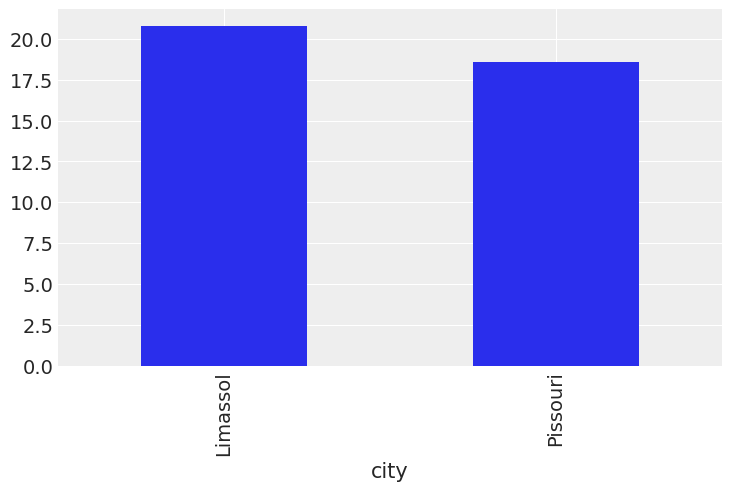

In [20]:
df[['month', 'main_feels_like', 'city']].groupby(['city']).mean()['main_feels_like'].plot(kind='bar')

<AxesSubplot:xlabel='month', ylabel='main_feels_like'>

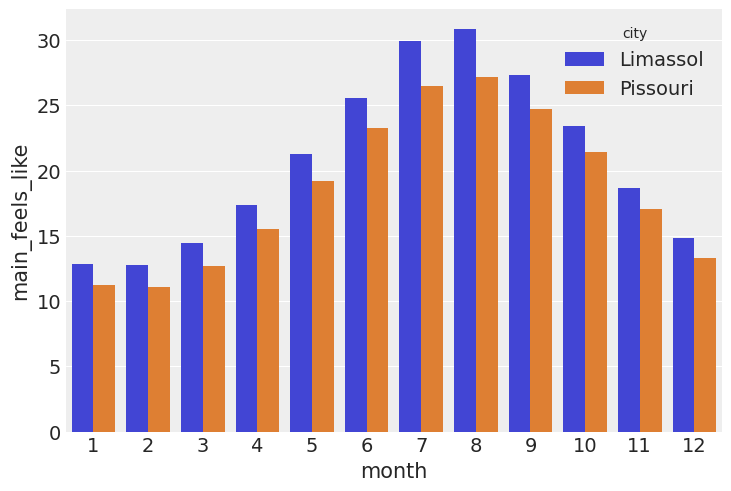

In [21]:
mean_month = df[['month', 'main_feels_like', 'city']].groupby(['city', 'month']).mean()['main_feels_like'].reset_index()
sns.barplot(data=mean_month, x='month', y='main_feels_like', hue='city')

<AxesSubplot:xlabel='city'>

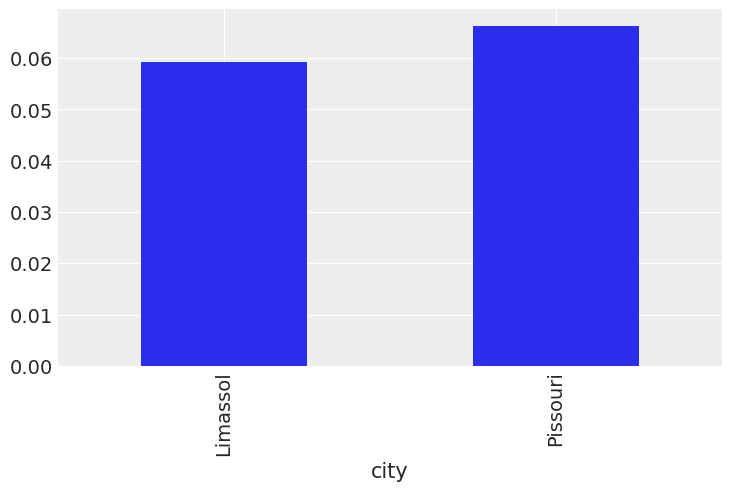

In [22]:
df[['month', 'rain', 'city']].groupby(['city']).mean()['rain'].plot(kind='bar')

<AxesSubplot:xlabel='month', ylabel='rain'>

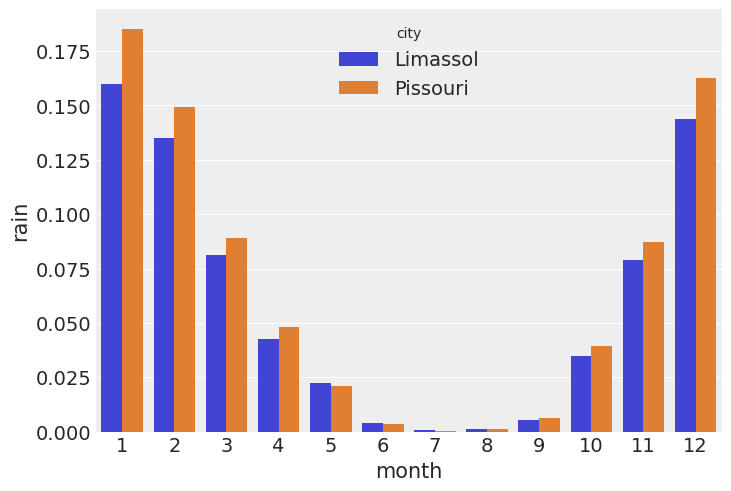

In [23]:
mean_month = df[['month', 'rain', 'city']].groupby(['city', 'month']).mean()['rain'].reset_index()
sns.barplot(data=mean_month, x='month', y='rain', hue='city')

### Mean temperatures from prior distribution

In [2]:
prior_mean = np.linspace(start=15, stop=30, num=7)
prior_mean_pissouri = np.hstack((prior_mean[1],prior_mean[:], np.flip(prior_mean)[1:-2]))
months = np.arange(1,13)
mean_mapping = dict(zip(months, prior_mean_pissouri))

In [3]:
print(mean_mapping)

{1: 17.5, 2: 15.0, 3: 17.5, 4: 20.0, 5: 22.5, 6: 25.0, 7: 27.5, 8: 30.0, 9: 27.5, 10: 25.0, 11: 22.5, 12: 20.0}


In [4]:
month_names = list(calendar.month_name)[1:]

In [5]:
prior_mean = np.linspace(start=13, stop=28, num=7)
prior_mean_pissouri = np.hstack((prior_mean[1],prior_mean[:], np.flip(prior_mean)[1:-2]))

In [6]:
prior_mean = pd.DataFrame()
prior_mean['month'] = month_names
prior_mean['prior_mean_pissouri'] = prior_mean_pissouri
prior_mean['prior_mean_limassol'] = prior_mean_pissouri +2

In [7]:
prior_mean

,month,prior_mean_pissouri,prior_mean_limassol
0,January,15.5,17.5
1,February,13.0,15.0
2,March,15.5,17.5
3,April,18.0,20.0
4,May,20.5,22.5
5,June,23.0,25.0
6,July,25.5,27.5
7,August,28.0,30.0
8,September,25.5,27.5
9,October,23.0,25.0


### Proportion of rainy hours for prior distributions

In [8]:
prior_rain = np.linspace(start=20, stop=0.1, num=7)
prior_rain_all = np.hstack((prior_rain[1],prior_rain[:], np.flip(prior_rain)[1:-2]))
prior_rain = pd.DataFrame()
prior_rain['month'] = month_names
prior_rain['proportion of rainy hours'] = prior_rain_all/100
prior_rain

,month,proportion of rainy hours
0,January,0.166833
1,February,0.200000
2,March,0.166833
3,April,0.133667
4,May,0.100500
5,June,0.067333
6,July,0.034167
7,August,0.001000
8,September,0.034167
9,October,0.067333


## Bayesian models

### Temperature comparison

In [171]:
class TemperatureModel():
    
    def __init__(self, month, is_day=None):

        self.month = month
        self.is_day = is_day
    

    
    def fit(self, df, low_mean_pissouri, high_mean_pissouri):
                
        if self.is_day == None:
            temperature_df = df[df['month']==self.month][['city', 'main_feels_like']]
        else:
            temperature_df = df[(df['month']==self.month)&(df['is_day']==self.is_day)][['year', 'city', 'main_feels_like']]
        self.temperature_df = temperature_df
        
        pissouri_feels_like = temperature_df[temperature_df['city']=='Pissouri']['main_feels_like'].values #.groupby('year')['main_feels_like'].mean().reset_index()['main_feels_like'].values
        limassol_feels_like = temperature_df[temperature_df['city']=='Limassol']['main_feels_like'].values #.groupby('year')['main_feels_like'].mean().reset_index()['main_feels_like'].values
        self.pissouri_feels_like = pissouri_feels_like
        self.limassol_feels_like = limassol_feels_like
        
        prior_mean = np.linspace(start=low_mean_pissouri, stop=high_mean_pissouri, num=7)
        prior_mean_pissouri = np.hstack((prior_mean[1],prior_mean[:], np.flip(prior_mean)[1:-2]))
        months = np.arange(1,13)
        mean_mapping = dict(zip(months, prior_mean_pissouri))
        mean_normal = mean_mapping[self.month]
        
        
        with pm.Model() as temperature_model:
            
            #Prior
            mu_p = pm.Normal("Mean Pissouri", mu=mean_normal, sigma=0.5)
            mu_l = pm.Normal("Mean Limassol", mu=mean_normal+2, sigma=0.5)
            sigma = pm.HalfNormal("Sigma", 1.5, shape=2)
            
            #Likelihood
            pm.Normal("Pissouri", mu=mu_p, sigma=sigma[0], observed=pissouri_feels_like)
            pm.Normal("Limassol", mu=mu_l, sigma=sigma[1], observed=limassol_feels_like)
                 
            #Posterior
            plausible_values_temp = pm.sample(random_seed=rng)
            
            
            prior_samples = pm.sample_prior_predictive(random_seed=rng)
            plausible_values_temp.extend(prior_samples)
            posterior_predictives = pm.sample_posterior_predictive(plausible_values_temp, random_seed=rng) 
            plausible_values_temp.extend(posterior_predictives)

                
        self.plausible_values_temp = plausible_values_temp
        self.temperature_model = temperature_model
        return self   
        
    
    # Add representation of the class
    def __repr__(self):
        return f"TemperatureModel(month={self.month}, is_day={self.is_day})"

### Check single model

In [172]:
model = TemperatureModel(5,1).fit(df, 13, 28)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


### Visual representation of the model

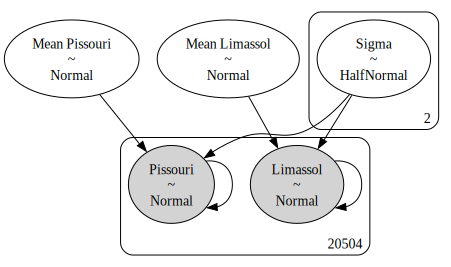

In [173]:
pm.model_to_graphviz(model.temperature_model)

### Plot priors

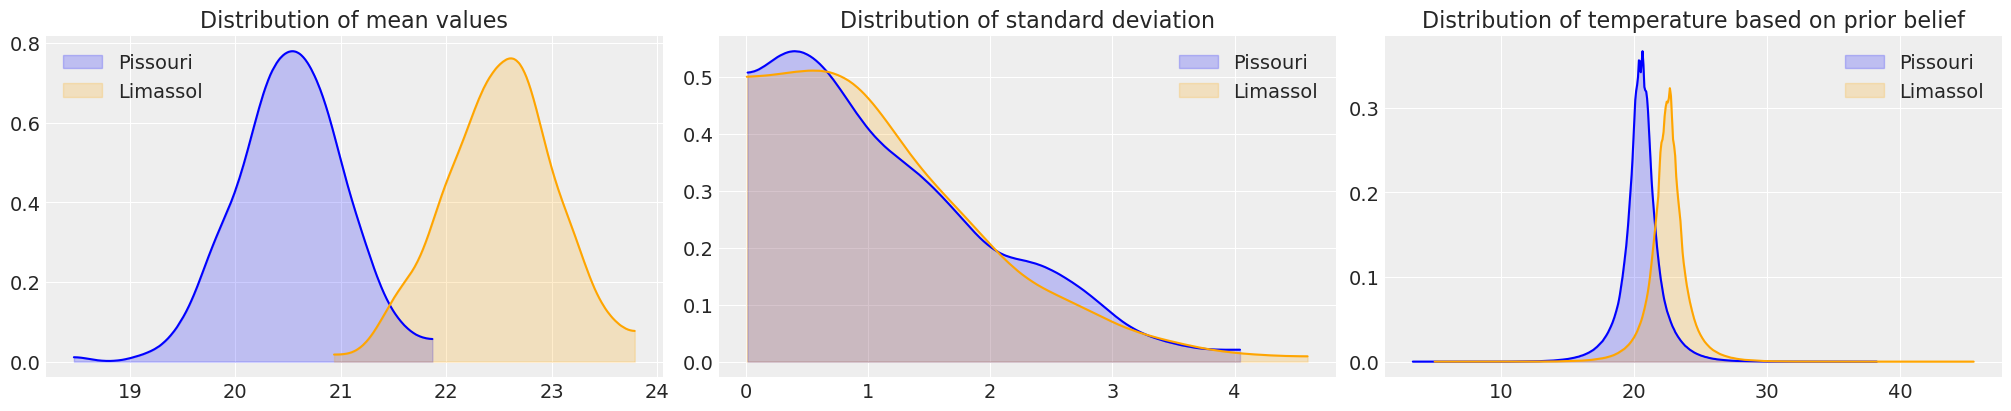

In [174]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
az.plot_dist(model.plausible_values_temp.prior_predictive['Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[2])
az.plot_dist(model.plausible_values_temp.prior_predictive['Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[2]);
az.plot_dist(model.plausible_values_temp.prior['Mean Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[0])
az.plot_dist(model.plausible_values_temp.prior['Mean Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[0])
az.plot_dist(model.plausible_values_temp.prior['Sigma'][0][:,0], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[1])
az.plot_dist(model.plausible_values_temp.prior['Sigma'][0][:,1], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[1])
;
axes[0].title.set_text('Distribution of mean values')
axes[1].title.set_text('Distribution of standard deviation')
axes[2].title.set_text('Distribution of temperature based on prior belief')
plt.savefig('prior_temp.png')

### Trace

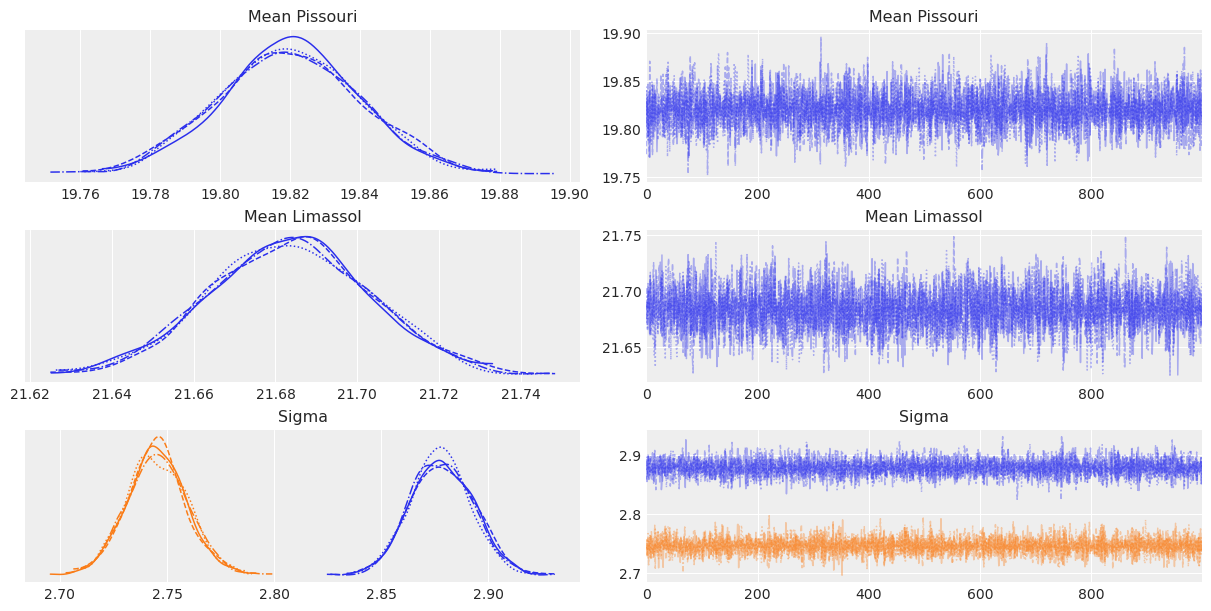

In [175]:
az.plot_trace(model.plausible_values_temp);
plt.savefig('trace_temp.png')

### Plot posterior and posterior predictive

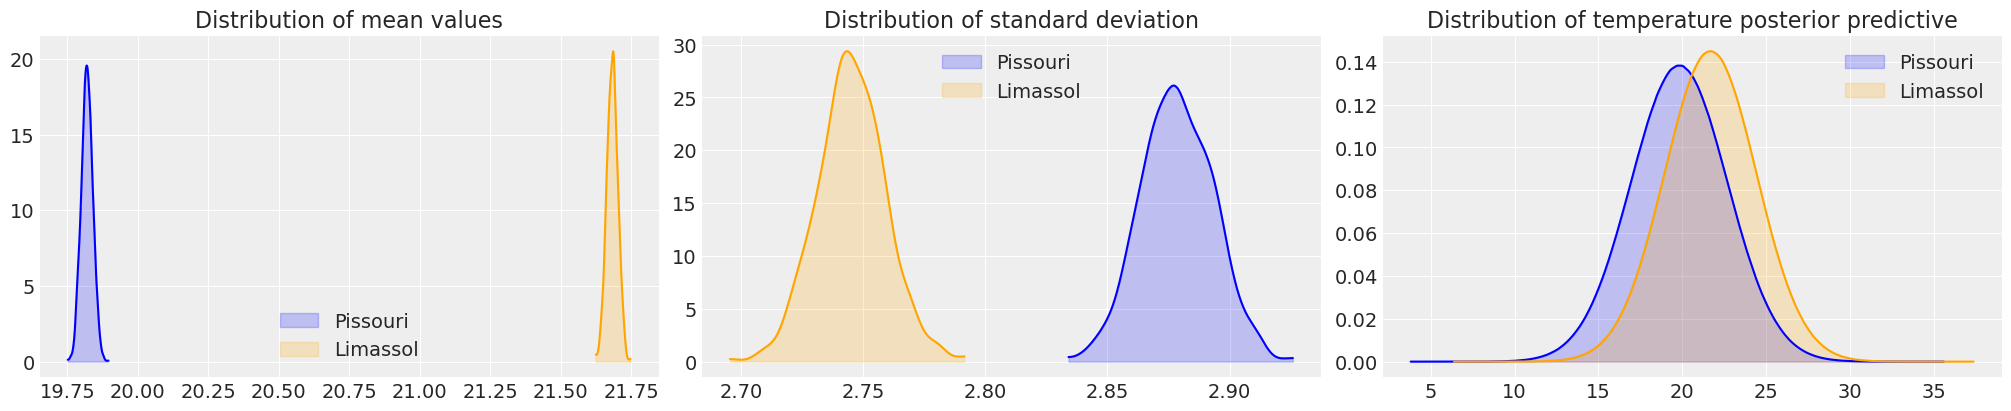

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
az.plot_dist(model.plausible_values_temp.posterior_predictive['Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[2])
az.plot_dist(model.plausible_values_temp.posterior_predictive['Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[2]);
az.plot_dist(model.plausible_values_temp.posterior['Mean Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[0])
az.plot_dist(model.plausible_values_temp.posterior['Mean Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[0])
az.plot_dist(model.plausible_values_temp.posterior['Sigma'][0][:,0], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[1])
az.plot_dist(model.plausible_values_temp.posterior['Sigma'][0][:,1], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[1]);
axes[0].title.set_text('Distribution of mean values')
axes[1].title.set_text('Distribution of standard deviation')
axes[2].title.set_text('Distribution of temperature posterior predictive')
plt.savefig('posterior_temp.png')

### Compare prior and posterior

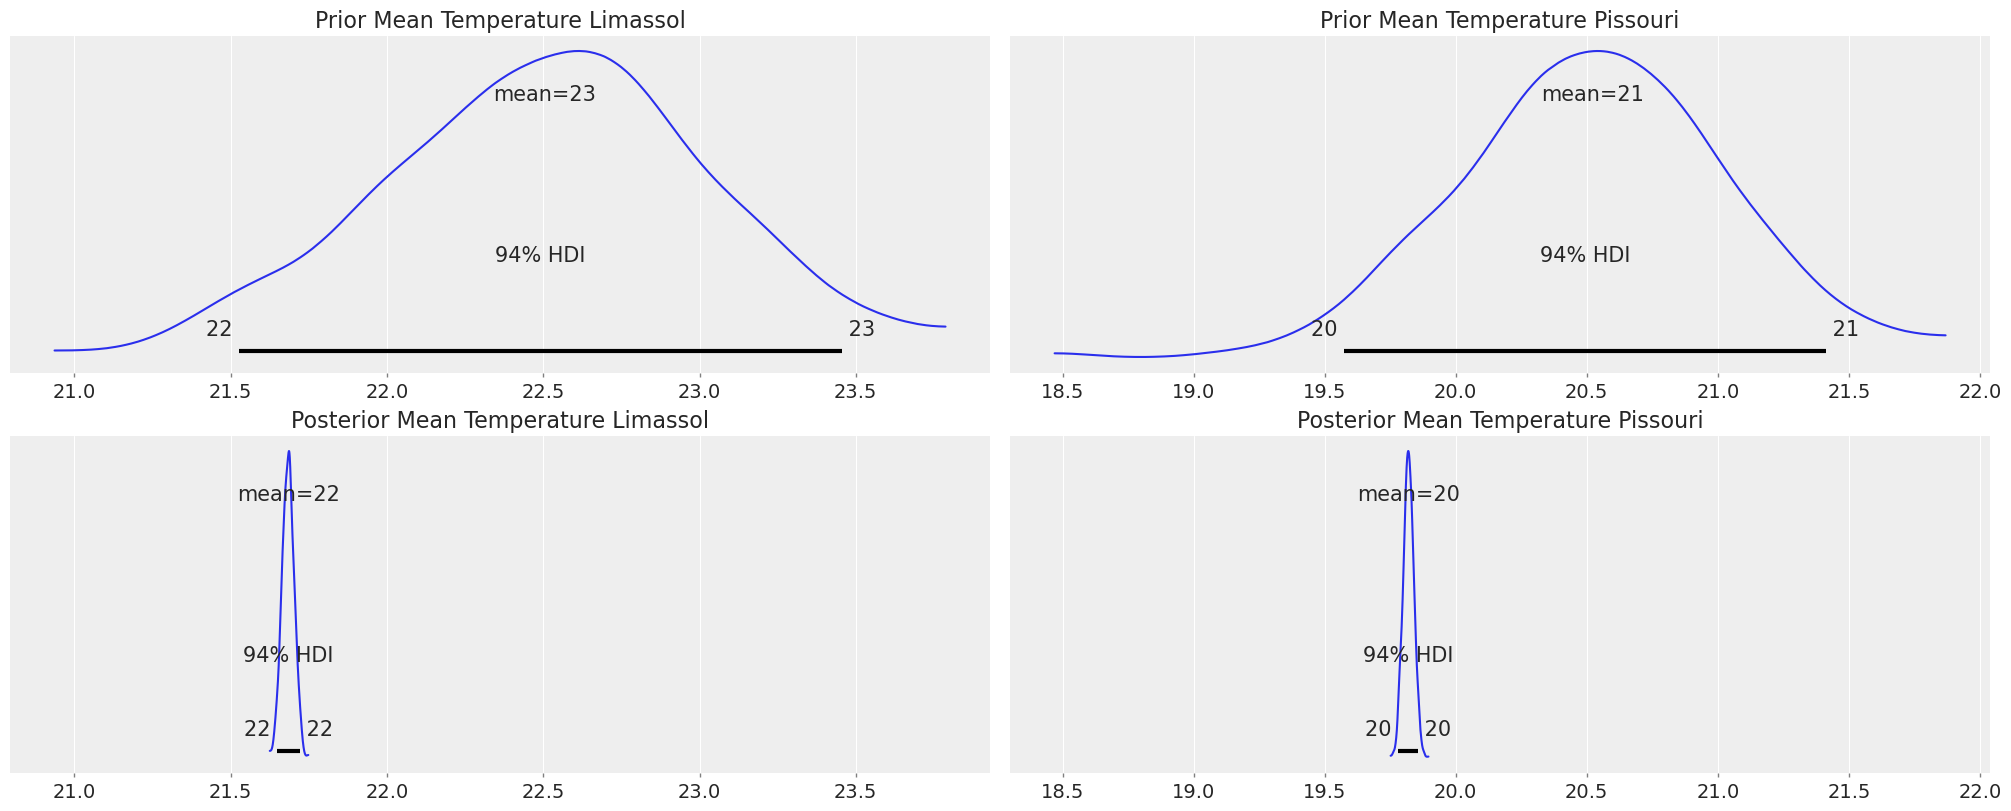

In [177]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharex='col')
az.plot_posterior(model.plausible_values_temp.prior["Mean Limassol"], ax=axes[0])
axes[0][0].set_title('Prior Mean Temperature Limassol')
az.plot_posterior(model.plausible_values_temp.prior["Mean Pissouri"], ax=axes[0][1])
axes[0][1].set_title('Prior Mean Temperature Pissouri')
az.plot_posterior(model.plausible_values_temp.posterior["Mean Limassol"], ax=axes[1][0])
axes[1][0].set_title('Posterior Mean Temperature Limassol')
az.plot_posterior(model.plausible_values_temp.posterior["Mean Pissouri"], ax=axes[1][1]);
axes[1][1].set_title('Posterior Mean Temperature Pissouri')
plt.savefig('temp_prior_posterior.png')

### Analytical comparison of prior and posterior

In [178]:
prior = az.summary(model.plausible_values_temp.prior, kind='stats')[:]
posterior = az.summary(model.plausible_values_temp.posterior, kind='stats')[:]
prior['distribution'] = 'Prior'
posterior['distribution'] = 'Posterior'
all_dist = pd.concat([prior, posterior], axis=0)

In [179]:
all_dist.sort_index()[:4]

,mean,sd,hdi_3%,hdi_97%,distribution
Mean Limassol,22.504,0.512,21.526,23.455,Prior
Mean Limassol,21.684,0.019,21.648,21.721,Posterior
Mean Pissouri,20.521,0.500,19.575,21.412,Prior
Mean Pissouri,19.820,0.020,19.781,19.857,Posterior


### Difference of mean temperatures

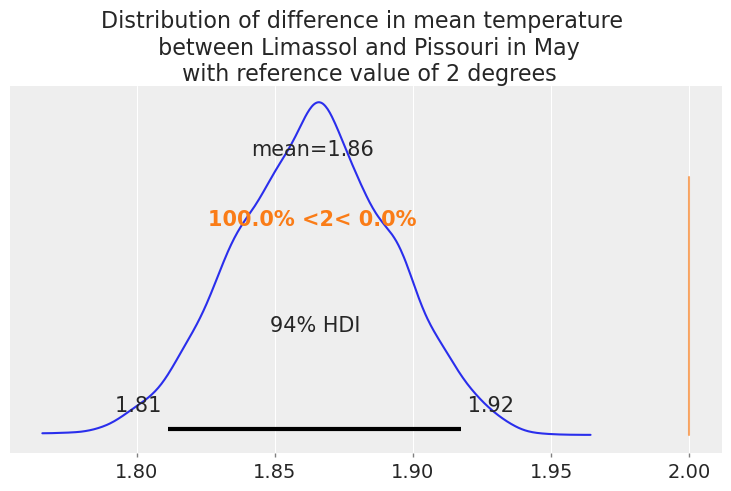

In [180]:
diff = (
    model.plausible_values_temp.posterior["Mean Limassol"]
    - model.plausible_values_temp.posterior["Mean Pissouri"]
)
az.plot_posterior(diff, ref_val=2, round_to=3);
plt.title('Distribution of difference in mean temperature \n between Limassol and Pissouri in May\n with reference value of 2 degrees')
plt.savefig('diff_may_temp.png')

### Effect size

In [181]:
sigma1 = model.plausible_values_temp.posterior["Sigma"][0][:,0]
sigma2 = model.plausible_values_temp.posterior["Sigma"][0][:,1]
# https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html
effect_size = diff / np.sqrt((sigma1**2 + sigma2**2) / 2)

Text(0.5, 1.0, 'Effect size')

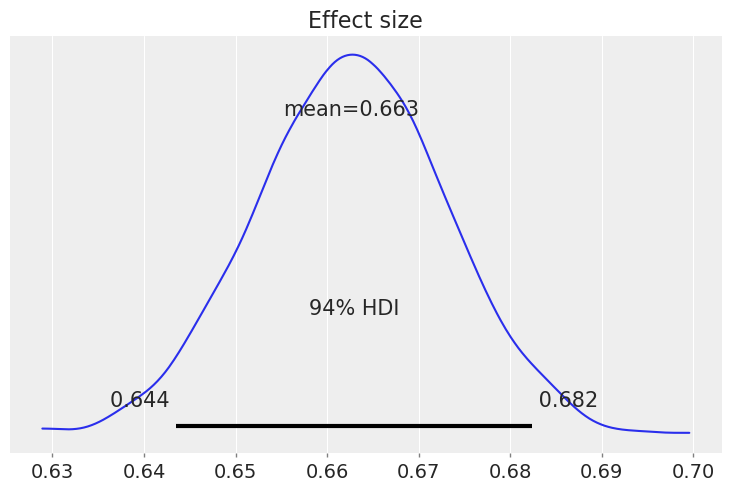

In [182]:
az.plot_posterior(effect_size, round_to=3)
plt.title('Effect size')

In [183]:
az.summary(effect_size)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.663,0.01,0.644,0.682,0.0,0.0,5437.0,2899.0,1.0


## Mdels for each month

In [184]:
months = np.arange(1,13)
list_of_models = list()
for i in months:
    list_of_models.append(TemperatureModel(i,1).fit(df, 13, 28))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mean Pissouri, Mean Limassol, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


### Posterior predictive

In [185]:
limassol_temp = list()
pissouri_temp = list()
for i in list_of_models:
    limassol_temp.append(i.plausible_values_temp.posterior_predictive["Limassol"])
    pissouri_temp.append(i.plausible_values_temp.posterior_predictive["Pissouri"])   

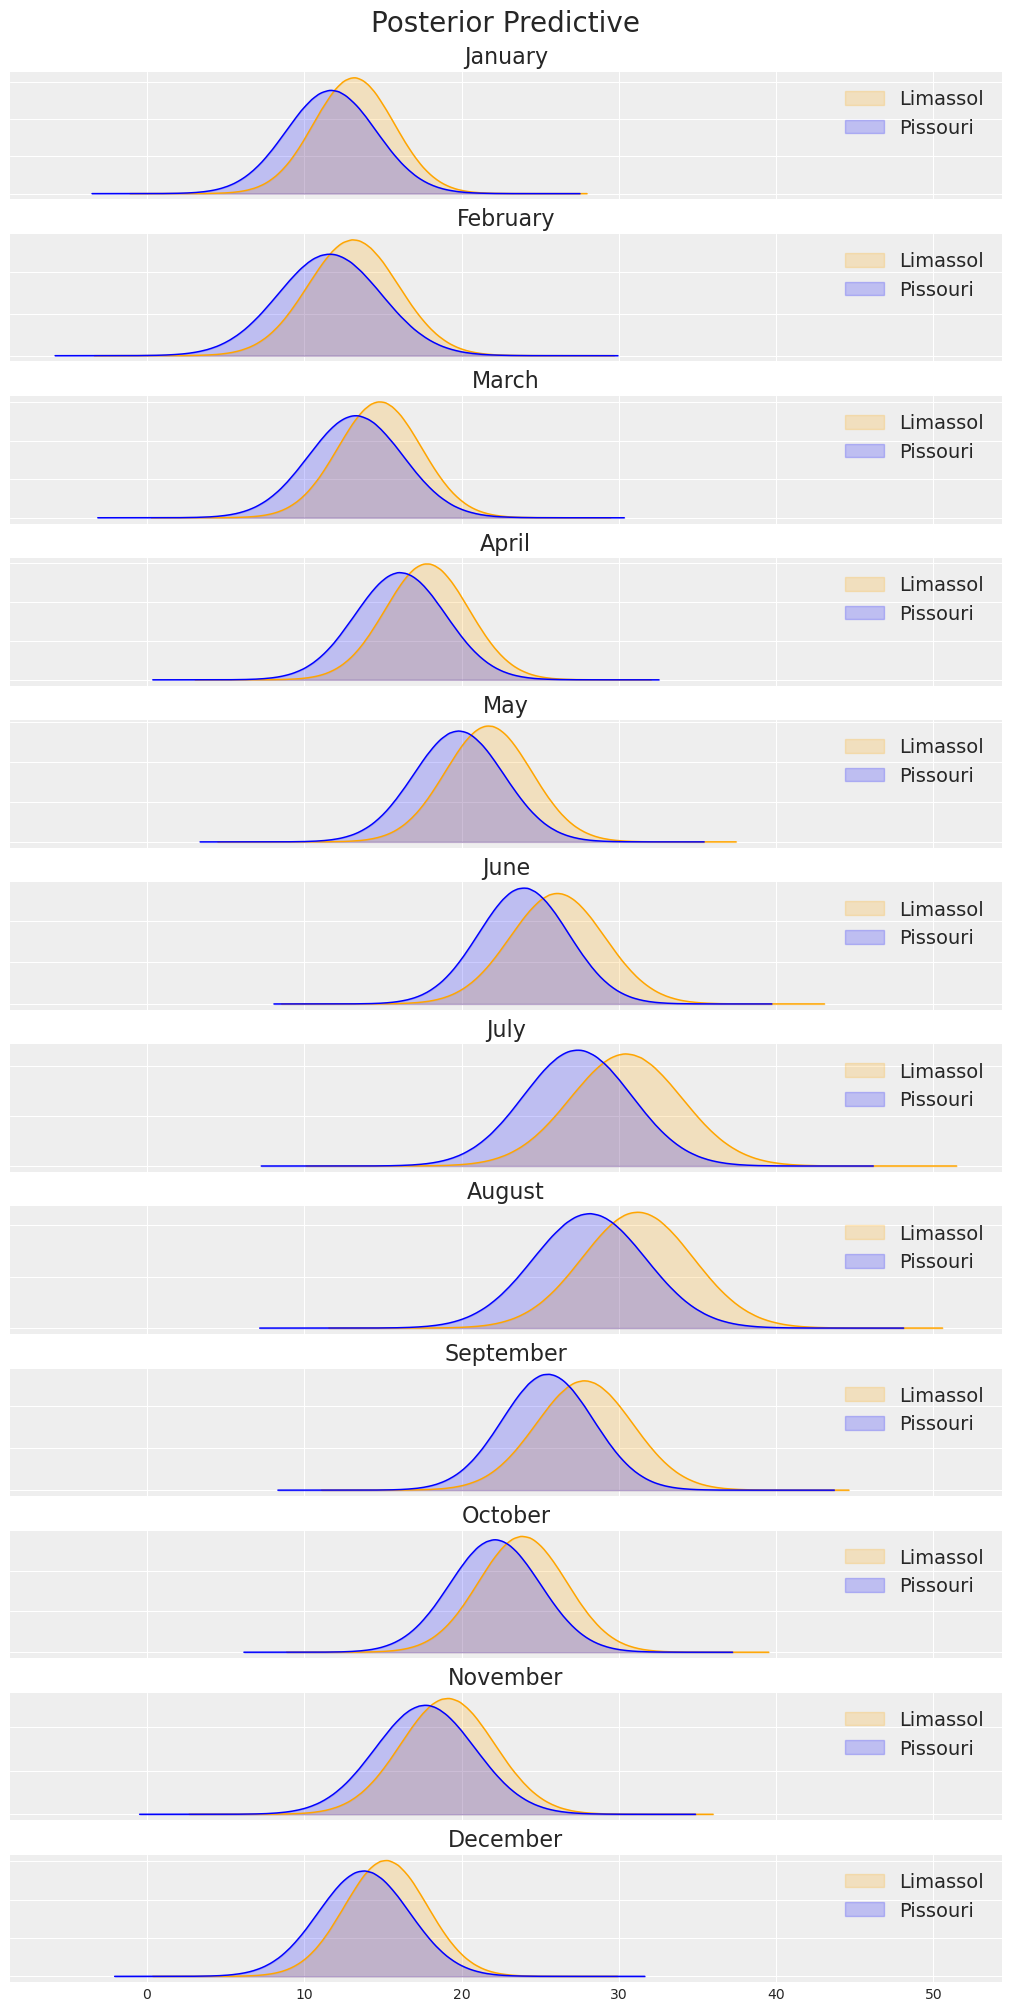

In [186]:
fig, axes = plt.subplots(12, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Posterior Predictive', fontsize=20)
for piss_temp, lima_temp, ax, m in zip(pissouri_temp, limassol_temp, axes.ravel(), month_names):
    az.plot_dist(lima_temp, color='orange', fill_kwargs={'alpha': 0.2}, ax=ax, label='Limassol', textsize=10)
    az.plot_dist(piss_temp, color='blue', fill_kwargs={'alpha': 0.2}, ax=ax, label='Pissouri', textsize=10)
    ax.title.set_text(m)
    ax.tick_params(left=False, labelleft=False)
plt.savefig('posterior_predictive_temp_new.png')

### Comparison of differences for each month

In [187]:
list_of_diff = list()
for i in list_of_models:
    diff = (
    i.plausible_values_temp.posterior["Mean Limassol"]
    - i.plausible_values_temp.posterior["Mean Pissouri"]
        )
    list_of_diff.append(diff)

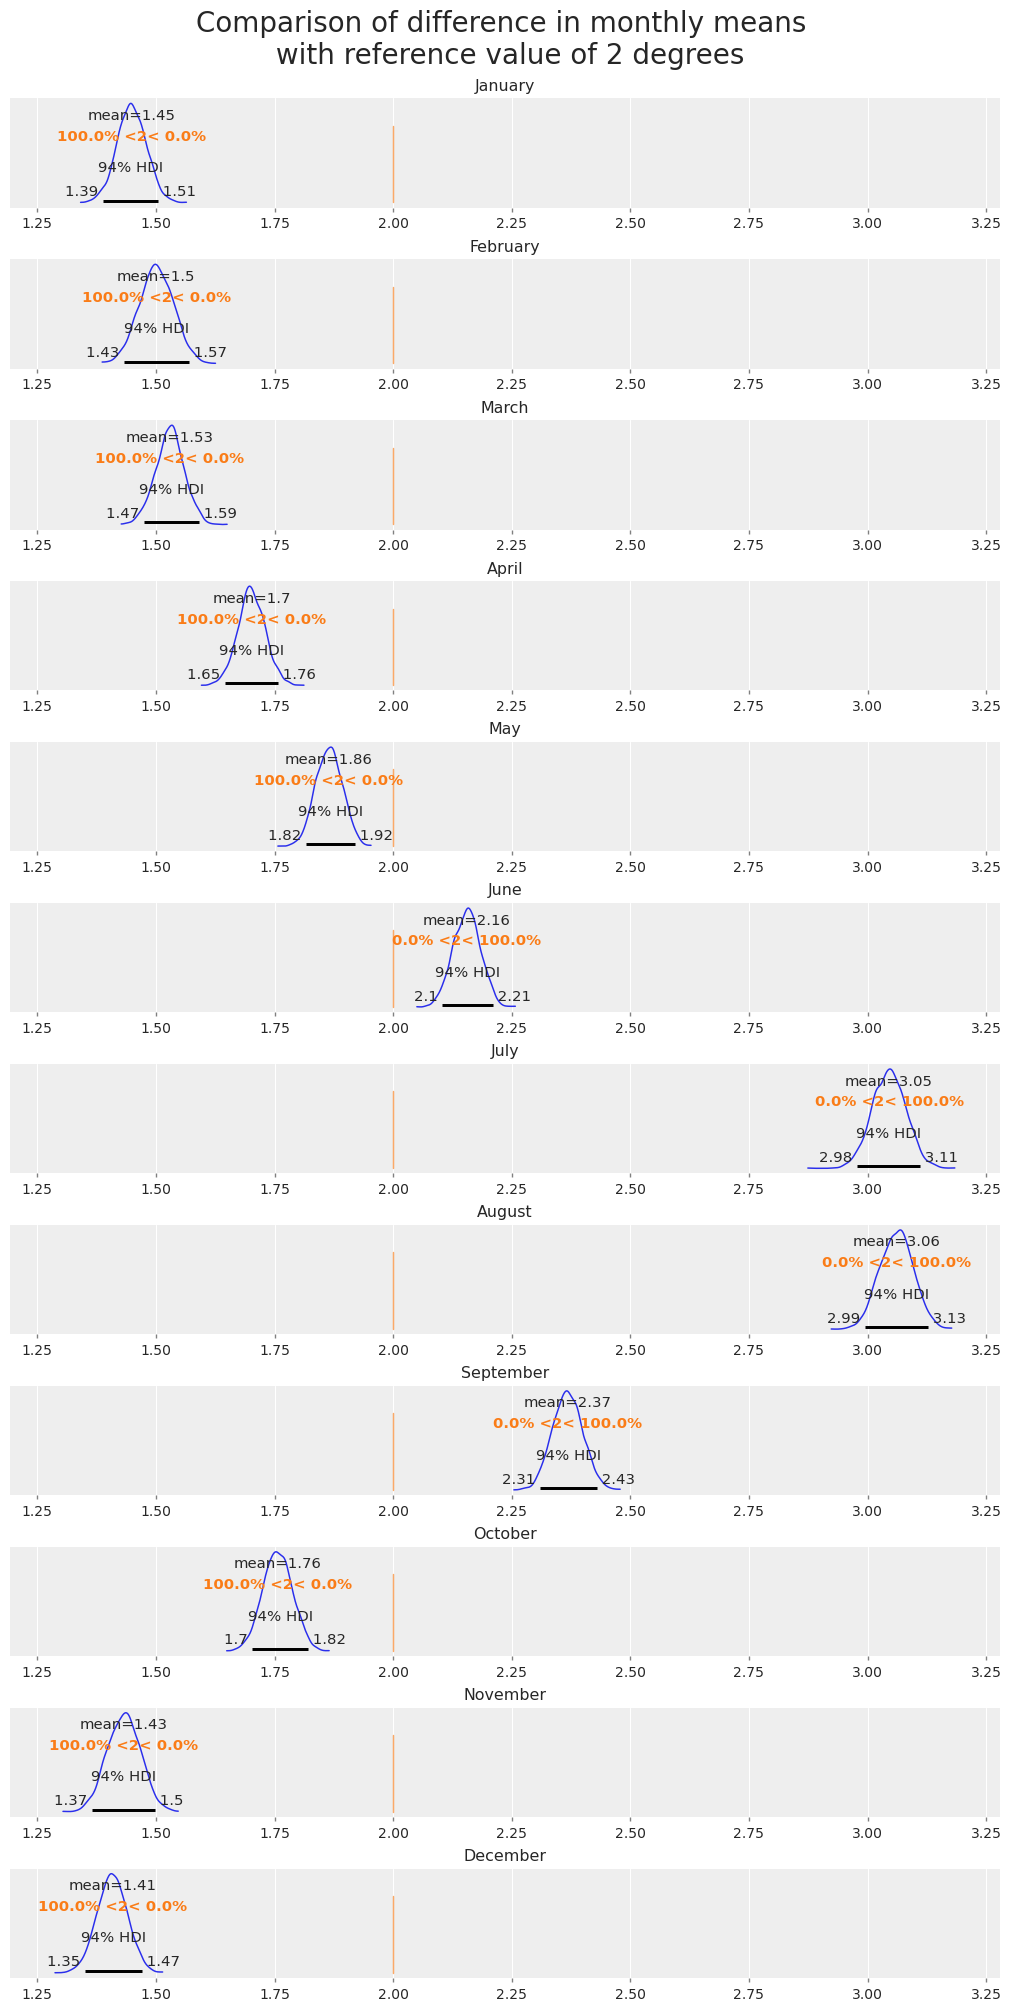

In [188]:

fig, axes = plt.subplots(12, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Comparison of difference in monthly means \n with reference value of 2 degrees', fontsize=20)
for diffs, ax, m in zip(list_of_diff, axes.ravel(), month_names):
    az.plot_posterior(diffs, ref_val=2, round_to=3, ax=ax, textsize=10)
    ax.title.set_text(m)
plt.savefig('plot_temp_monthly.png')

## Differences in proportion of rainy hours

In [24]:
class RainModel():
    
    def __init__(self, month, is_day=None):

        self.month = month
        self.is_day = is_day
    

    
    def fit(self, df, rain_high):
                
        if self.is_day == None:
            rain_df = df[df['month']==self.month][['city', 'rain']]
        else:
            rain_df = df[(df['month']==self.month)&(df['is_day']==self.is_day)][['city', 'rain']]
        self.rain_df = rain_df
        
        pissouri_rain = rain_df[rain_df['city']=='Pissouri']['rain']
        limassol_rain = rain_df[rain_df['city']=='Limassol']['rain']
        
        number_of_values_limassol = limassol_rain.shape[0]
        number_of_values_pissouri = pissouri_rain.shape[0]
        
        prior_rain = np.linspace(start=rain_high, stop=0.1, num=7)
        prior_rain_all = np.hstack((prior_rain[1],prior_rain[:], np.flip(prior_rain)[1:-2]))
        months = np.arange(1,13)
        rain_mapping = dict(zip(months, prior_rain_all))
        rain_beta = rain_mapping[self.month]

        
        with pm.Model() as rain_model: 
            # Prior distribution
            beta_l = pm.Beta('Beta Limassol', alpha=rain_beta, beta=100-rain_beta)
            beta_p = pm.Beta('Beta Pissouri', alpha=rain_beta, beta=100-rain_beta)
            # likelihood distribution
            likelihood_l = pm.Binomial('Rain Likelihood Limassol', n=number_of_values_limassol, p=beta_l, observed=limassol_rain.sum())
            likelihood_p = pm.Binomial('Rain Likelihood Pissouri', n=number_of_values_pissouri, p=beta_p, observed=pissouri_rain.sum())
            # Posterior
            plausible_values_rain = pm.sample(2000, random_seed=rng)
            
            
            prior_samples = pm.sample_prior_predictive(random_seed=rng)
            plausible_values_rain.extend(prior_samples)
            posterior_predictives = pm.sample_posterior_predictive(plausible_values_rain, random_seed=rng) 
            plausible_values_rain.extend(posterior_predictives)
                
        self.plausible_values_rain = plausible_values_rain
        self.rain_model = rain_model
        return self   
        
    
    # Add representation of the class
    def __repr__(self):
        return f"RainModel(month={self.month}, is_day={self.is_day})"

### Instantiate a single model

In [25]:
single_model = RainModel(5, 1).fit(df, 20)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.


### Graphical representation of the model

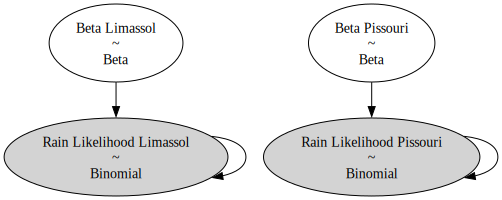

In [191]:
pm.model_to_graphviz(single_model.rain_model)

### Prior and prior predictive

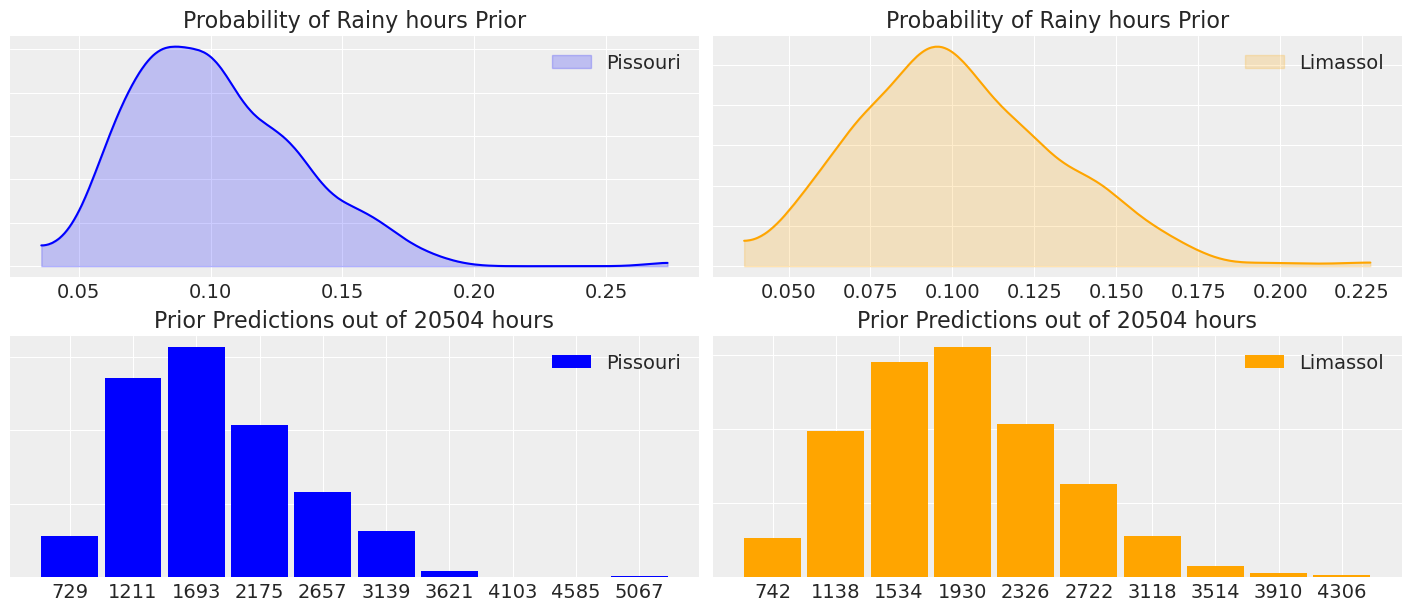

In [192]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
az.plot_dist(single_model.plausible_values_rain.prior_predictive['Rain Likelihood Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[1][0])
az.plot_dist(single_model.plausible_values_rain.prior_predictive['Rain Likelihood Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[1][1]);
az.plot_dist(single_model.plausible_values_rain.prior['Beta Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[0][0])
az.plot_dist(single_model.plausible_values_rain.prior['Beta Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[0][1])
axes[0][0].title.set_text('Probability of Rainy hours Prior')
axes[0][1].title.set_text('Probability of Rainy hours Prior')
axes[1][0].title.set_text(f'Prior Predictions out of {int(single_model.rain_df.shape[0]/2)} hours')
axes[1][1].title.set_text(f'Prior Predictions out of {int(single_model.rain_df.shape[0]/2)} hours')
for i in axes.ravel():
    i.tick_params(left=False, labelleft=False)
plt.savefig('prior_rain.png')

### Trace

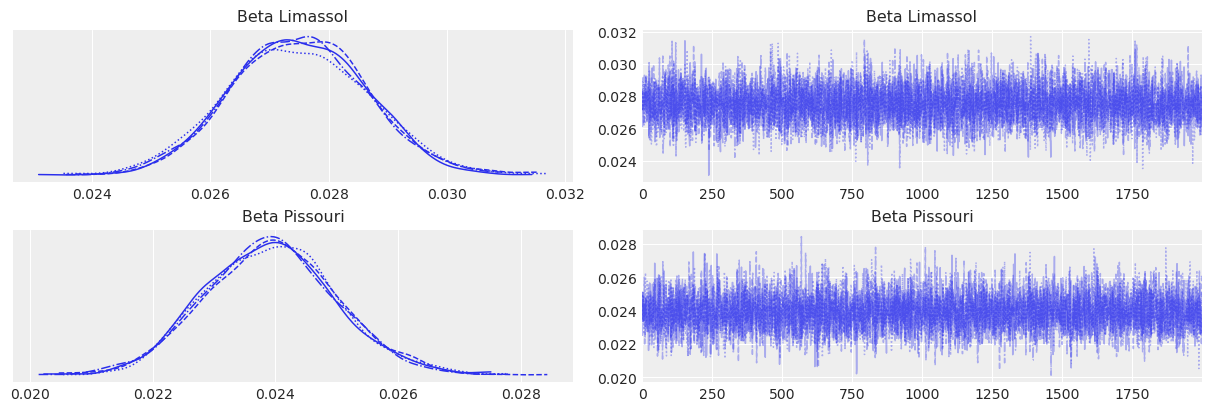

In [193]:
az.plot_trace(single_model.plausible_values_rain);
plt.savefig('trace_rain.png')

### Posterior and posterior predictive

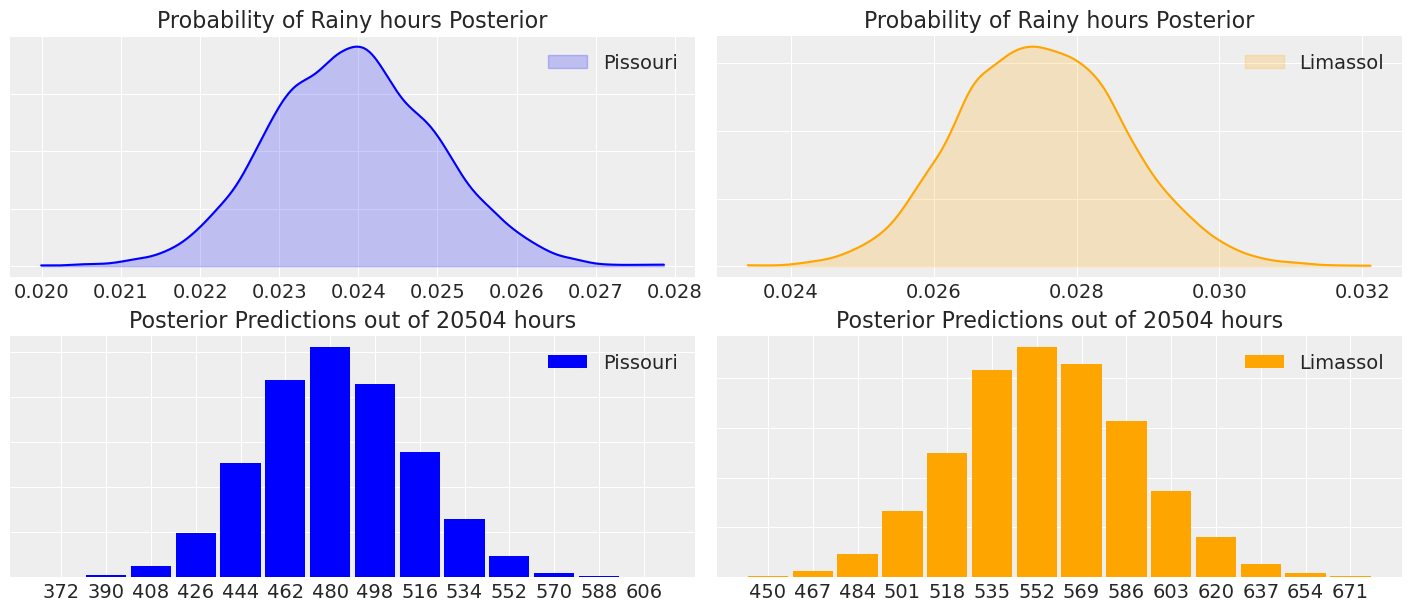

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
az.plot_dist(single_model.plausible_values_rain.posterior_predictive['Rain Likelihood Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[1][0])
az.plot_dist(single_model.plausible_values_rain.posterior_predictive['Rain Likelihood Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[1][1]);
az.plot_dist(single_model.plausible_values_rain.posterior['Beta Pissouri'], color='blue', fill_kwargs={'alpha': 0.2}, label='Pissouri',ax=axes[0][0])
az.plot_dist(single_model.plausible_values_rain.posterior['Beta Limassol'], color='orange',fill_kwargs={'alpha': 0.2}, label='Limassol',ax=axes[0][1])
axes[0][0].title.set_text('Probability of Rainy hours Posterior')
axes[0][1].title.set_text('Probability of Rainy hours Posterior')
axes[1][0].title.set_text(f'Posterior Predictions out of {int(single_model.rain_df.shape[0]/2)} hours')
axes[1][1].title.set_text(f'Posterior Predictions out of {int(single_model.rain_df.shape[0]/2)} hours')
for i in axes.ravel():
    i.tick_params(left=False, labelleft=False)
plt.savefig('posterior_rain_1.png')

### Prior and Posterior

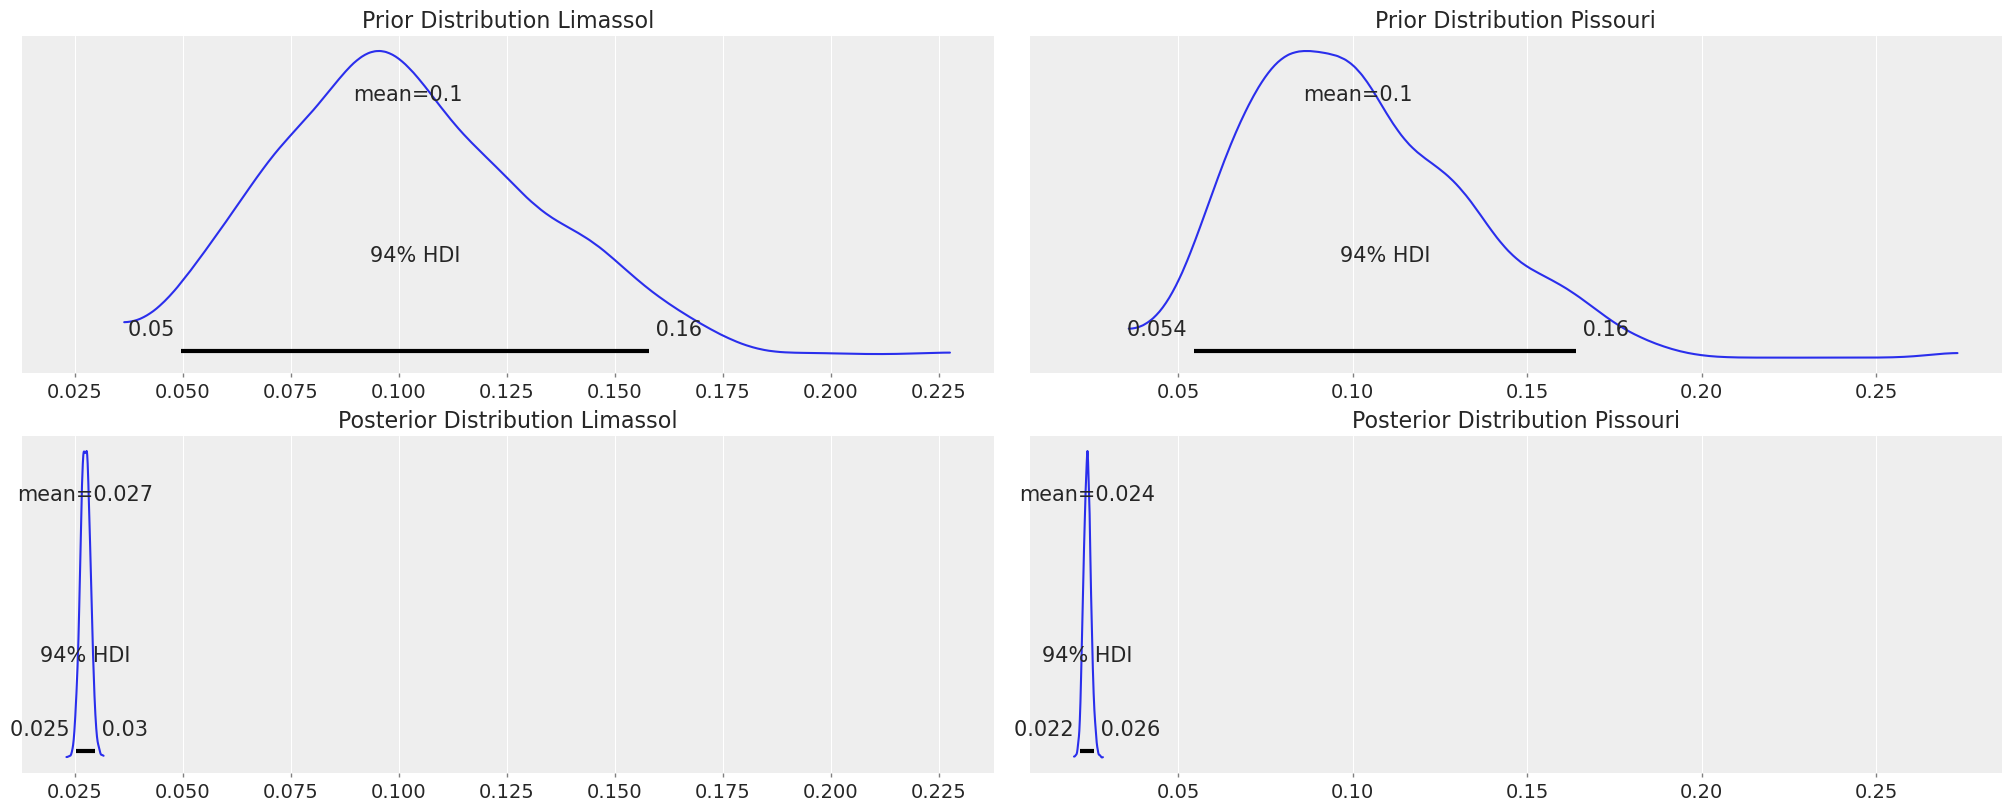

In [195]:
fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharex='col')
az.plot_posterior(single_model.plausible_values_rain.prior["Beta Limassol"], ax=axes[0][0])
az.plot_posterior(single_model.plausible_values_rain.prior["Beta Pissouri"], ax=axes[0][1])
az.plot_posterior(single_model.plausible_values_rain.posterior["Beta Limassol"], ax=axes[1][0])
az.plot_posterior(single_model.plausible_values_rain.posterior["Beta Pissouri"], ax=axes[1][1]);
axes[0][0].title.set_text('Prior Distribution Limassol')
axes[0][1].title.set_text('Prior Distribution Pissouri')
axes[1][0].title.set_text('Posterior Distribution Limassol')
axes[1][1].title.set_text('Posterior Distribution Pissouri')
plt.savefig('posterior_prior_rain.png')

### Prior and Posterior analytical

In [196]:
prior = az.summary(single_model.plausible_values_rain.prior, kind='stats')
posterior = az.summary(single_model.plausible_values_rain.posterior, kind='stats')
prior['distribution'] = 'Prior'
posterior['distribution'] = 'Posterior'
all_dist = pd.concat([prior, posterior], axis=0)

In [197]:
all_dist.sort_index()

,mean,sd,hdi_3%,hdi_97%,distribution
Beta Limassol,0.102,0.030,0.050,0.158,Prior
Beta Limassol,0.027,0.001,0.025,0.030,Posterior
Beta Pissouri,0.101,0.031,0.054,0.164,Prior
Beta Pissouri,0.024,0.001,0.022,0.026,Posterior


### Difference between proportions single model

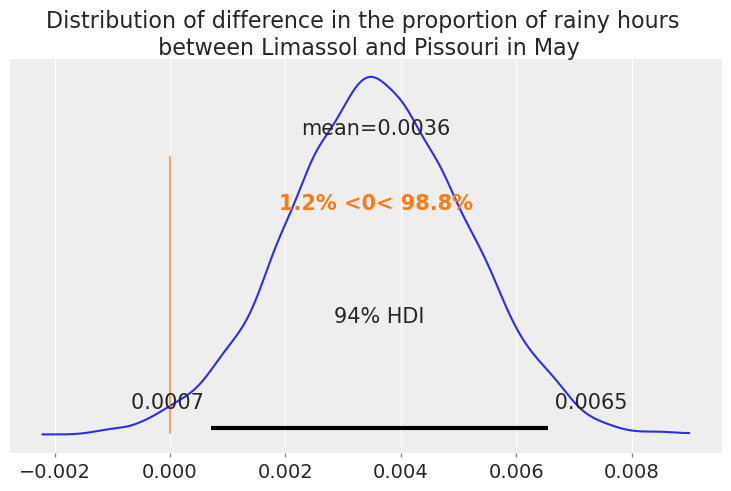

In [198]:
diff = (
    single_model.plausible_values_rain.posterior["Beta Limassol"]
    - single_model.plausible_values_rain.posterior["Beta Pissouri"]
)
az.plot_posterior(diff, ref_val=0, round_to=2);
plt.title('Distribution of difference in the proportion of rainy hours \n between Limassol and Pissouri in May')
plt.savefig('diff_rain.png')

### Effect size single model

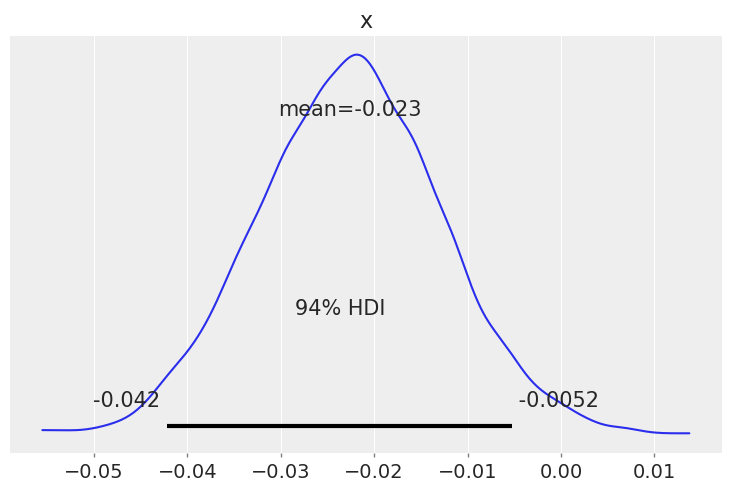

In [199]:
effect_1 = np.arcsin(np.sqrt(single_model.plausible_values_rain.posterior["Beta Limassol"]))*2
effect_2 = np.arcsin(np.sqrt(single_model.plausible_values_rain.posterior["Beta Pissouri"]))*2
effect = effect_2 - effect_1
az.plot_posterior(effect);

### Models for each month

In [200]:
months = np.arange(1,13)
list_of_models_rain = list()
for i in months:
    list_of_models_rain.append(RainModel(i,1).fit(df, 20))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta Limassol, Beta Pissouri]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


### Posterior for each month

In [201]:
pissouri_rain = list()
limassol_rain = list()
for i in list_of_models_rain:
    pissouri_rain.append(i.plausible_values_rain.posterior["Beta Pissouri"])
    limassol_rain.append(i.plausible_values_rain.posterior["Beta Limassol"]) 
       

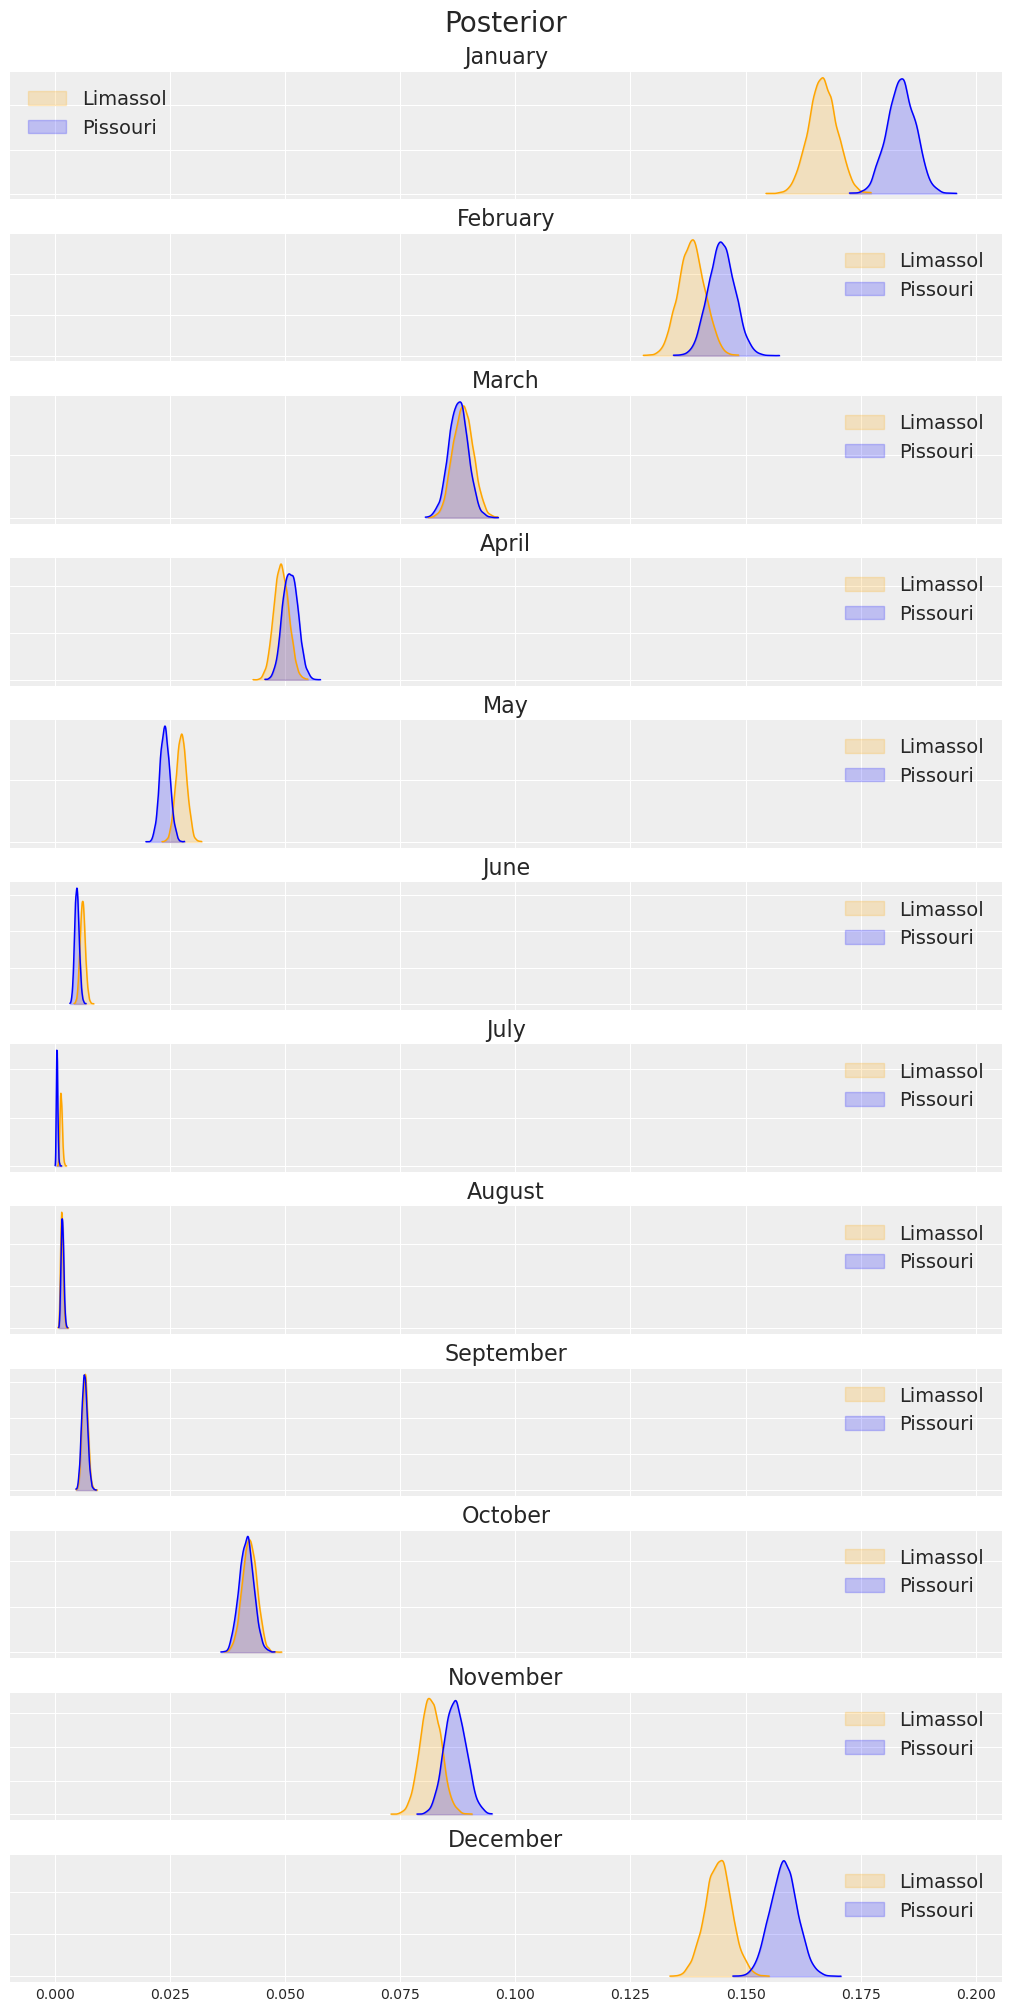

In [202]:
fig, axes = plt.subplots(12, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Posterior', fontsize=20)
for piss_rain, lima_rain, ax, m in zip(pissouri_rain, limassol_rain, axes.ravel(), month_names):
    az.plot_dist(lima_rain, color='orange', fill_kwargs={'alpha': 0.2}, ax=ax, label='Limassol', textsize=10)
    az.plot_dist(piss_rain, color='blue', fill_kwargs={'alpha': 0.2}, ax=ax, label='Pissouri', textsize=10)
    ax.title.set_text(m)
    ax.tick_params(left=False, labelleft=False)
plt.savefig('posterior_rain.png')

### Difference in proportions for each month

In [203]:
list_of_diff_rain = list()
for i in list_of_models_rain:
    diff = (
    i.plausible_values_rain.posterior["Beta Limassol"]
    - i.plausible_values_rain.posterior["Beta Pissouri"]
        )
    list_of_diff_rain.append(diff)

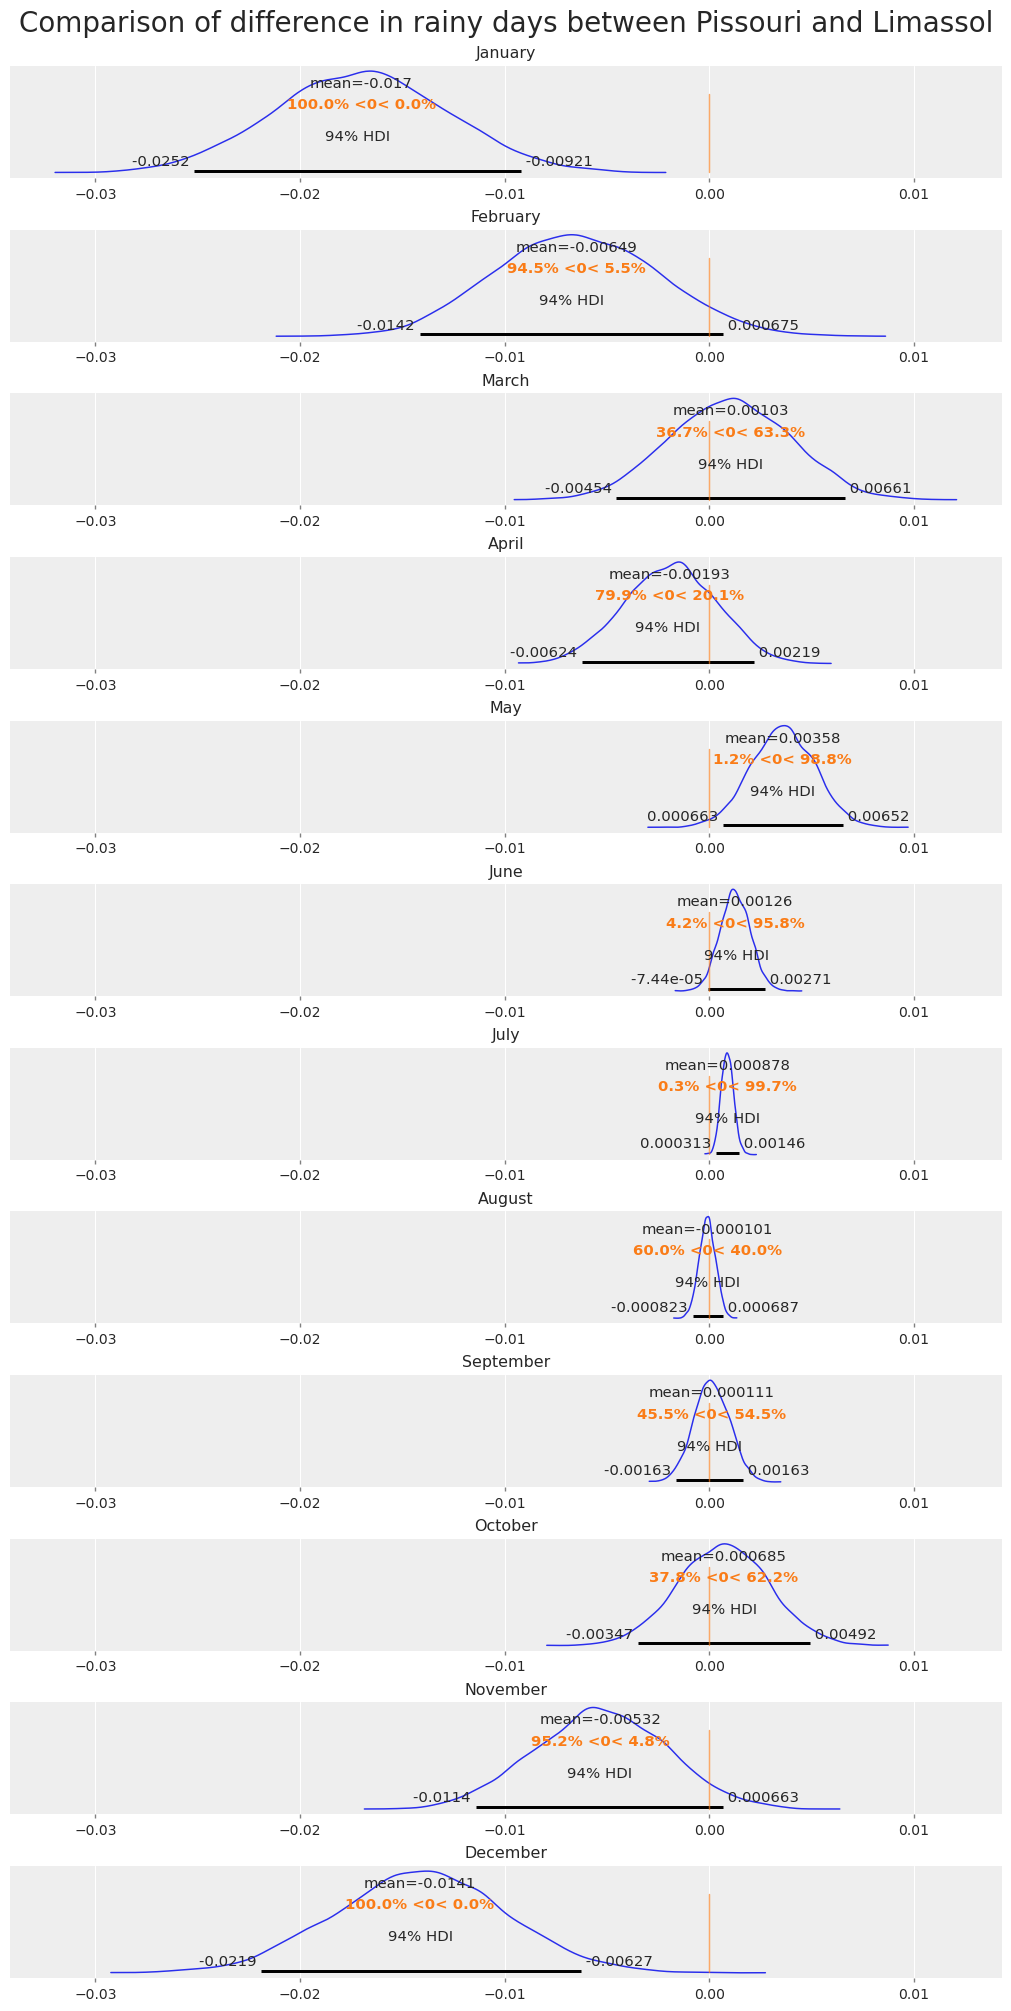

In [204]:
fig, axes = plt.subplots(12, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Comparison of difference in rainy days between Pissouri and Limassol', fontsize=20)
for diffs, ax, m in zip(list_of_diff_rain, axes.ravel(), month_names):
    az.plot_posterior(diffs, ref_val=0, round_to=3, ax=ax, textsize=10)
    ax.title.set_text(m)
plt.savefig('plot_diff_rain.png')

### Effect size for each month

In [205]:
effect_size_list = list()
for i in list_of_models_rain:
    effect_limassol = np.arcsin(np.sqrt(i.plausible_values_rain.posterior["Beta Limassol"]))*2
    effect_pissouri = np.arcsin(np.sqrt(i.plausible_values_rain.posterior["Beta Pissouri"]))*2
    effect = effect_pissouri - effect_limassol
    effect_size_list.append(effect)


In [207]:
list_df = list()
for effect, m in zip(effect_size_list, month_names):
    df = az.summary(effect, kind='stats')
    df['month'] = m
    df['effect_size'] = df['mean'].abs()
    list_df.append(df)
    
df = pd.concat(list_df, axis=0)

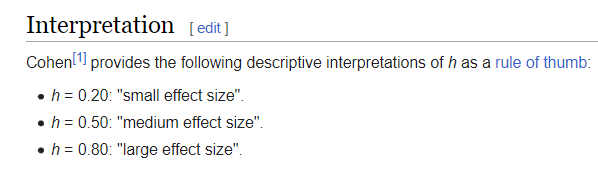

In [208]:
selections = [df['effect_size']<=0.2,((df['effect_size']>0.2)&(df['effect_size']<=0.5)), df['effect_size']>0.5]
choices = ['small','medium','large']

In [209]:
df['effect'] = np.select(selections, choices)

In [210]:
df

,mean,sd,hdi_3%,hdi_97%,month,effect_size,effect
x,0.045,0.011,0.024,0.066,January,0.045,small
x,0.019,0.012,-0.003,0.039,February,0.019,small
x,-0.004,0.011,-0.023,0.016,March,0.004,small
x,0.009,0.010,-0.010,0.029,April,0.009,small
x,-0.023,0.010,-0.042,-0.005,May,0.023,small
x,-0.017,0.010,-0.036,0.001,June,0.017,small
x,-0.029,0.010,-0.048,-0.011,July,0.029,small
x,0.002,0.010,-0.016,0.021,August,0.002,small
x,-0.001,0.011,-0.021,0.020,September,0.001,small
x,-0.003,0.011,-0.024,0.018,October,0.003,small
